In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## 1. 데이터 전처리 및 Data Loader 정의

In [2]:
tr = pd.read_csv('IMDB_train.csv')
tr

,words,sentiment
0,the;as;you;with;out;themselves;powerful;lets;l...,1
1,the;thought;solid;thought;senator;do;making;to...,0
2,the;as;there;in;at;by;br;of;sure;many;br;of;pr...,0
3,the;of;and;and;they;halfway;of;identity;went;p...,1
4,the;sure;themes;br;only;acting;i;i;was;favouri...,0
...,...,...
24995,the;as;it;is;ludicrous;on;not;rape;br;program;...,1
24996,the;slaughter;susan;effects;is;following;like;...,0
24997,the;this;is;anything;tv;tormented;it;is;genera...,0
24998,the;bar;reverse;me;we;endearing;was;song;deep;...,1


- 토큰 사전 만들기 & 변환

In [3]:
x_train = tr['words'].apply(lambda x: x.split(';')).tolist()
words = set()
for i in x_train:
    words.update(i)
idx2word = {i+1:v for i, v in enumerate(words)}
word2idx = {v:i for i, v in idx2word.items()}
maxlen = max([len(x) for x in x_train])

In [4]:
my_test = []
for x in x_train:
    my_test.append([word2idx.get(i, 0) for i in x])

- 원핫인코딩

In [5]:
def onehot(seq, dim=10000):
    results = np.zeros((len(seq), dim))
    for i, sequence in enumerate(seq):
        results[i, sequence] = 1
    return results

In [6]:
onehot(my_test).shape

(25000, 10000)

- 데이터 전처리 함수 정의

In [7]:
class IMDBdata(Dataset):
    def __init__(self, file_path):
        super().__init__()
        df = pd.read_csv(file_path)
        my_words = df['words'].apply(lambda x: x.split(';')).tolist()
        my_x = []    
        for w in my_words:
            my_x.append([word2idx.get(i, 0) for i in w])
        my_x = onehot(my_x)
        self.x = my_x
        self.y = df['sentiment'].values

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        x = torch.FloatTensor(self.x[idx])
        y = torch.FloatTensor([self.y[idx]])
        return x,y
    

- Data Loader 정의

In [8]:
bsize=128
train_set = IMDBdata('./IMDB_train.csv')
train_dataloader = DataLoader(train_set, batch_size=bsize)
test_set = IMDBdata('./IMDB_test.csv')
test_dataloader = DataLoader(test_set, batch_size=bsize)

In [9]:
for x, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {x.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([128, 10000])
Shape of y: torch.Size([128, 1]) torch.float32


## 2. 모델 정의

In [10]:
class IMDBsentiment(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(10000, 4),
            nn.ReLU(),
            nn.Linear(4, 4),
            nn.ReLU(),
            nn.Linear(4, 1),
            nn.Sigmoid()
            )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [11]:
model = IMDBsentiment().to(device)
print(model)

IMDBsentiment(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=10000, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


- [손실함수](https://pytorch.org/docs/stable/nn.html#loss-functions)와 [옵티마이저](https://pytorch.org/docs/stable/optim.html) 정의

In [12]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3)

## 3. 모델 학습

In [13]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        # 손실 점수 계산
        pred = model(x)
        loss = loss_fn(pred, y)
        # 기울기 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

#        if batch % 100 == 0:
#            loss, current = loss.item(), (batch + 1) * len(x)
#            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

- 성능 검증 함수 정의

In [14]:
def test(dataloader, model, loss_fn, t='Test'):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += ((pred>0.5).to(torch.float) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(t, f"Error: \n Accuracy: {(correct*100):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct*100, test_loss

- 학습

In [15]:
epochs = 20
train_history = []
test_history = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    train_history.append(test(train_dataloader, model, loss_fn,'Train'))
    test_history.append(test(test_dataloader, model, loss_fn,'Test'))
print("Done!")

Epoch 1
-------------------------------


Train Error: 
 Accuracy: 92.1%, Avg loss: 0.622917 

Test Error: 
 Accuracy: 87.7%, Avg loss: 0.630265 

Epoch 2
-------------------------------
Train Error: 
 Accuracy: 94.2%, Avg loss: 0.557499 

Test Error: 
 Accuracy: 88.1%, Avg loss: 0.576911 

Epoch 3
-------------------------------
Train Error: 
 Accuracy: 95.2%, Avg loss: 0.487172 

Test Error: 
 Accuracy: 88.0%, Avg loss: 0.523548 

Epoch 4
-------------------------------
Train Error: 
 Accuracy: 96.0%, Avg loss: 0.418866 

Test Error: 
 Accuracy: 87.9%, Avg loss: 0.473461 

Epoch 5
-------------------------------
Train Error: 
 Accuracy: 96.5%, Avg loss: 0.355521 

Test Error: 
 Accuracy: 88.0%, Avg loss: 0.429786 

Epoch 6
-------------------------------
Train Error: 
 Accuracy: 97.0%, Avg loss: 0.298098 

Test Error: 
 Accuracy: 87.7%, Avg loss: 0.395494 

Epoch 7
-------------------------------
Train Error: 
 Accuracy: 97.3%, Avg loss: 0.250694 

Test Error: 
 Accuracy: 87.5%, Avg loss: 0.372032 

Epoch 8
-----------------

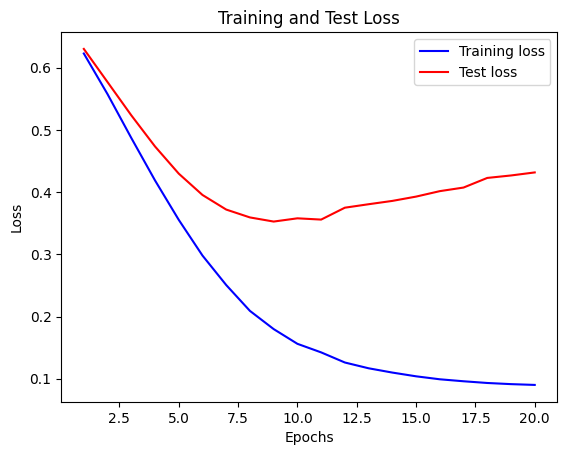

In [16]:
tr_loss = [i[1] for i in train_history]
te_loss = [i[1] for i in test_history]
epochs= range(1, len(tr_loss) + 1)
plt.plot(epochs, tr_loss, 'blue', label='Training loss')
plt.plot(epochs, te_loss, 'red', label='Test loss')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

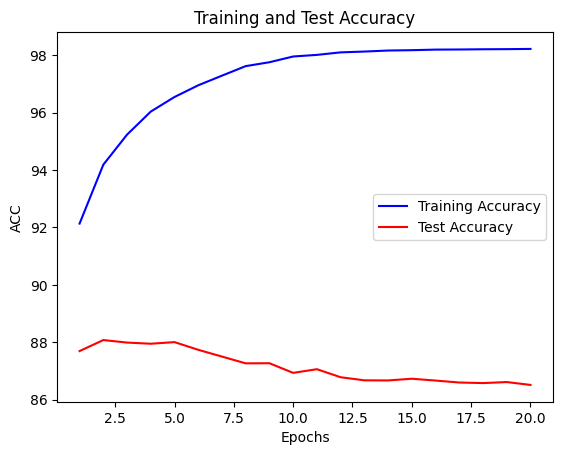

In [17]:
tr_acc = [i[0] for i in train_history]
te_acc = [i[0] for i in test_history]
epochs= range(1, len(tr_acc) + 1)
plt.plot(epochs, tr_acc, 'blue', label='Training Accuracy')
plt.plot(epochs, te_acc, 'red', label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('ACC')
plt.legend();

## 4. 과대적합을 줄이기 위해 Epoch 조정

In [18]:
class IMDBsentiment(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(10000, 4),
            nn.ReLU(),
            nn.Linear(4, 4),
            nn.ReLU(),
            nn.Linear(4, 1),
            nn.Sigmoid()
            )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

model = IMDBsentiment().to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3)
epochs = 4
train_history = []
test_history = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    train_history.append(test(train_dataloader, model, loss_fn,'Train'))
    test_history.append(test(test_dataloader, model, loss_fn,'Test'))
print("Done!")

Epoch 1
-------------------------------
Train Error: 
 Accuracy: 91.0%, Avg loss: 0.386614 

Test Error: 
 Accuracy: 87.9%, Avg loss: 0.416280 

Epoch 2
-------------------------------
Train Error: 
 Accuracy: 93.5%, Avg loss: 0.211091 

Test Error: 
 Accuracy: 89.0%, Avg loss: 0.287535 

Epoch 3
-------------------------------
Train Error: 
 Accuracy: 94.7%, Avg loss: 0.164696 

Test Error: 
 Accuracy: 88.9%, Avg loss: 0.281725 

Epoch 4
-------------------------------
Train Error: 
 Accuracy: 95.6%, Avg loss: 0.138207 

Test Error: 
 Accuracy: 88.4%, Avg loss: 0.295530 

Done!
